In [1]:
#!conda install seaborn

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

### To-do
&nbsp;&nbsp; 1. Pull in the data (This includes distance calculation) <br>
&nbsp;&nbsp; 2. Run around with the categorical data and extract data from timestamped details <br>
&nbsp;&nbsp; 3. Do basic exploratory analysis <br>
&nbsp;&nbsp; 4. Create categorical data matrix and continuous data matrix <br>
&nbsp;&nbsp; 5. Create tensors and embedding sizes for categorical data <br>
&nbsp;&nbsp; 6. Create model, optimizer and criterion <br>
&nbsp;&nbsp; 7. Build train model <br>
&nbsp;&nbsp; 8. Run test <br>
&nbsp;&nbsp; 9. Save model, load model <br>
&nbsp;&nbsp;10. Create program to directly run data transformation and through model

#### 1. Pull in the data

In [3]:
df=pd.read_csv('..//Data//NYCTaxiFares.csv')

In [4]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df['distance_km']=haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [7]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


#### 2. Run around with the categorical data and extract data from timestamped details

In [8]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

In [9]:
df['pickup_datetime'][:5]

0   2010-04-19 08:17:56+00:00
1   2010-04-17 15:43:53+00:00
2   2010-04-17 11:23:26+00:00
3   2010-04-11 21:25:03+00:00
4   2010-04-17 02:19:01+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [10]:
#converting EST to NewYork time since all the data is taken from NYC
df['date_timeEST']=df['pickup_datetime']-pd.Timedelta(hours=4)

In [11]:
#Creating various columns that are extracted data from the timestamp
df['hours']=df['date_timeEST'].dt.hour
df['weekday']=df['date_timeEST'].dt.strftime('%a')
df['AM_PM']=np.where(df['hours']<12,"AM","PM")

In [12]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,date_timeEST,hours,weekday,AM_PM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,Mon,AM
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,Sat,AM
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,Sat,AM
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,Sun,PM
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,Fri,PM


#### 3. Data Exploration

In [13]:
df_cont=df.copy()
df_cont.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','fare_class','hours','weekday','AM_PM'],axis=1,inplace=True)

In [14]:
#correlation of all significant continuous variables
df_cont.corr()

,fare_amount,passenger_count,distance_km
fare_amount,1.000000,0.034072,0.896157
passenger_count,0.034072,1.000000,0.023100
distance_km,0.896157,0.023100,1.000000


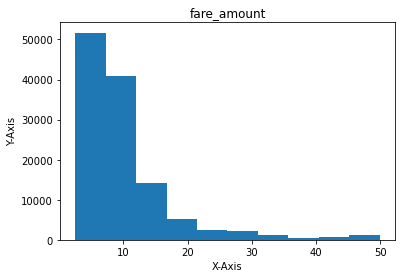

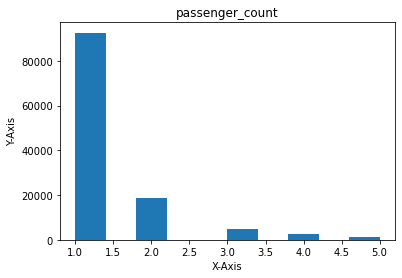

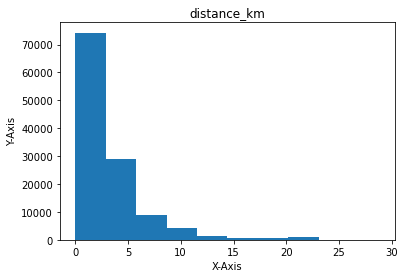

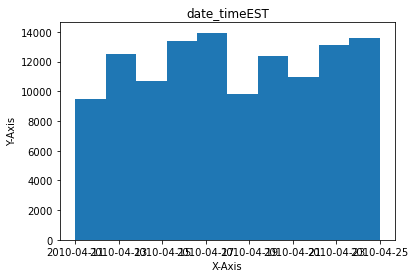

In [15]:
#Distribution of data of all continuous variables
for cont in df_cont.columns:
    plt.hist(df[cont])
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.title(cont)
    plt.show()

In [16]:
df_cat=df.copy()
df_cat.drop(['fare_amount','passenger_count','distance_km'],axis=1,inplace=True)

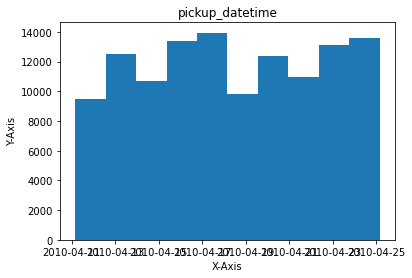

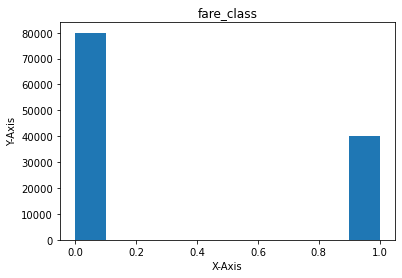

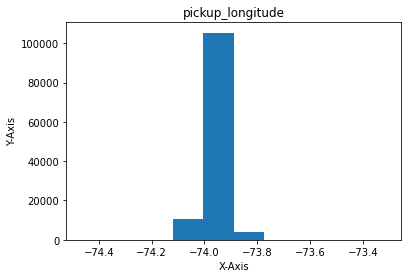

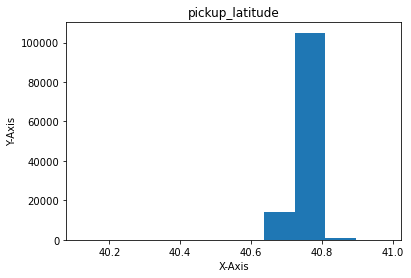

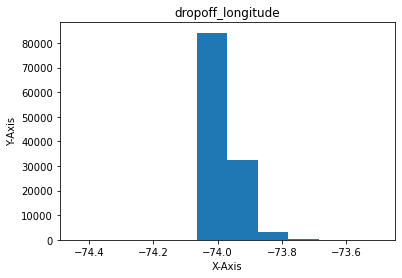

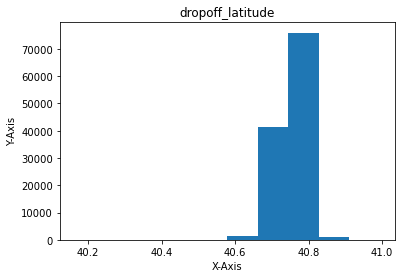

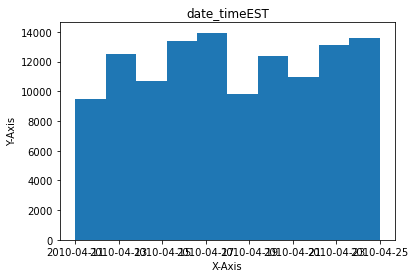

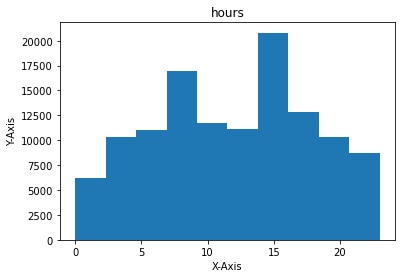

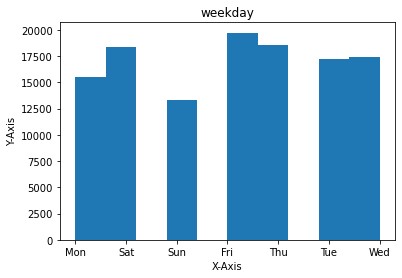

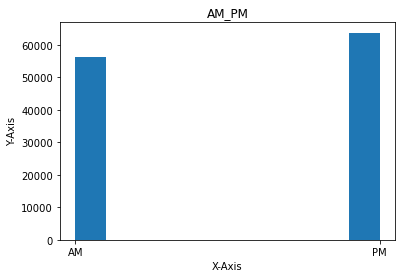

In [17]:
#Distribution of data of all continuous variables
for cat in df_cat.columns:
    plt.hist(df[cat])
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.title(cat)
    plt.show()

#### 4. Create categorical data matrix and continuous data matrix

In [18]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km', 'date_timeEST', 'hours', 'weekday',
       'AM_PM'],
      dtype='object')

In [19]:
#Creating an index of all categorical columns in index
cats=['hours','weekday','AM_PM']

In [20]:
#To use [category dtype].cat.codes, convert all non continuous objects to 'category' codes
for cat in cats:
    df[cat]=df[cat].astype('category')

In [21]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance_km                      float64
date_timeEST         datetime64[ns, UTC]
hours                           category
weekday                         category
AM_PM                           category
dtype: object

In [22]:
#Creating a matrix of all categorical columns of all int index values for each category 
#e.g. weekdays will have 7 codes (0-6), hours will have 24 codes (0-23)
cat_cols=np.stack([df[cat].cat.codes for cat in cats],axis=1)

In [23]:
#creating index of continuous columns
conts=['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km']

In [24]:
cont_cols=np.stack([df[col].values for col in conts],axis=1)

In [25]:
label=df['fare_amount'].values

In [26]:
print('category shape',cat_cols.shape)
print('continuous shape',cont_cols.shape)

category shape (120000, 3)
continuous shape (120000, 6)


#### 5.Create tensors and embedding sizes for categorical data

In [27]:
cat_tensor=torch.tensor(cat_cols,dtype=torch.long)
cont_tensor=torch.tensor(cont_cols,dtype=torch.float)
label_tensor=torch.tensor(label,dtype=torch.float)
print('category shape',cat_tensor.shape)
print('continuous shape',cont_tensor.shape)

category shape torch.Size([120000, 3])
continuous shape torch.Size([120000, 6])


##### 5a. Creating the embedding object
&nbsp;&nbsp; 1.  Creating embedding sizes : 
We need to create an embedding matrix of dimensions [original no.of cats, new numbers of cats] This is because we use only one-hotkey encoding, then the dimensions of each vector will by original no. of unique values of the categorical column which will be very large. Hence, we want to squeeze this to a more reasonable number of dimensions

In [28]:
cat_len=[df[col].nunique() for col in cats]

In [29]:
cat_len

[24, 7, 2]

In [30]:
embed_size=[(cat,min(50,int((cat+1)//2))) for cat in cat_len]

In [31]:
embed_size

[(24, 12), (7, 4), (2, 1)]

In [32]:
cat_embeddings = [nn.Embedding(initial,target) for initial,target in embed_size]

##### 5b. Trying to create an embedding matrix for the sample to see how it goes

In [33]:
cat_sample=torch.tensor(cat_cols[:4,:],dtype=torch.long)

In [34]:
print(cat_sample)

tensor([[ 4,  1,  0],
        [11,  2,  0],
        [ 7,  2,  0],
        [17,  3,  1]])


In [35]:
cat_embeddings

[Embedding(24, 12), Embedding(7, 4), Embedding(2, 1)]

In [36]:
#Attempting only for the hours data - to convert a coded 24-dimension feature into an embedding
embed_hour=cat_embeddings[0]
embed_hour

Embedding(24, 12)

In [37]:
#test sample of hours data
test_hour=torch.tensor(cat_sample[:,0],dtype=torch.long)

<ipython-input-37-581f525cfd62>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_hour=torch.tensor(cat_sample[:,0],dtype=torch.long)


In [38]:
test_hour

tensor([ 4, 11,  7, 17])

In [39]:
print(embed_hour(test_hour))
#We see that a 24 dimension variable now has only 12, which is a victory!!

tensor([[-0.8622, -0.4589, -0.3882,  2.1875,  0.7319, -0.6826,  0.9976,  0.3093,
         -0.5769,  0.3855,  2.0841, -0.6578],
        [ 0.1719, -1.4984,  1.5151,  0.1399,  1.6173,  0.2143, -2.1506,  0.9505,
         -1.2036,  1.2818, -0.9280, -0.1563],
        [-1.4625,  0.1978,  0.4445, -1.5443,  0.1917,  0.5728,  1.5959,  0.5367,
          1.0606, -0.8834,  0.3144,  0.3381],
        [-0.5294,  1.0591, -0.5086, -0.3494, -0.4488, -0.6346, -0.9714, -0.6094,
          1.7215,  0.1053,  1.5604, -0.4385]], grad_fn=<EmbeddingBackward>)


In [40]:
#Now attempting the same for all features in cat_sample
embeddings_test=[]
for i, embed in enumerate(cat_embeddings):
    embeddings_test.append(embed(cat_sample[:,i]))

In [41]:
for i,e in enumerate(embeddings_test):
    print(cats[i])
    print(e.shape)
    print(e)

hours
torch.Size([4, 12])
tensor([[-0.8622, -0.4589, -0.3882,  2.1875,  0.7319, -0.6826,  0.9976,  0.3093,
         -0.5769,  0.3855,  2.0841, -0.6578],
        [ 0.1719, -1.4984,  1.5151,  0.1399,  1.6173,  0.2143, -2.1506,  0.9505,
         -1.2036,  1.2818, -0.9280, -0.1563],
        [-1.4625,  0.1978,  0.4445, -1.5443,  0.1917,  0.5728,  1.5959,  0.5367,
          1.0606, -0.8834,  0.3144,  0.3381],
        [-0.5294,  1.0591, -0.5086, -0.3494, -0.4488, -0.6346, -0.9714, -0.6094,
          1.7215,  0.1053,  1.5604, -0.4385]], grad_fn=<EmbeddingBackward>)
weekday
torch.Size([4, 4])
tensor([[-0.1605, -0.9461,  0.6792,  0.6212],
        [-0.7289,  0.9246, -0.9244,  0.9909],
        [-0.7289,  0.9246, -0.9244,  0.9909],
        [ 0.3013,  0.8733, -1.1197, -1.1564]], grad_fn=<EmbeddingBackward>)
AM_PM
torch.Size([4, 1])
tensor([[ 0.9581],
        [ 0.9581],
        [ 0.9581],
        [-1.6076]], grad_fn=<EmbeddingBackward>)


###### SUCCESS ON SAMPLE!!

#### 6.Create model, optimizer and criterion

In [42]:
cont_tensor.shape

torch.Size([120000, 6])

In [43]:
class Model(nn.Module):
    def __init__(self,cat_cols,cont_cols,layer_count,output_features,embed_size_list,p=0.5): 
        '''
        args:
        cat_cols is the tensor of all categorical values (pre-embedding)
        n_cont=number of continuous variables (for batch normalization)
        cont_cols is the tensor of all continuous values
        input_features - number of parameters of input
        layer_count - a tuple of number of nodes of each hidden layer
        output_features = number of outputs expected
        embed_size_list is list of embedding sizes for the categorical values
        p = basically, the % of nodes to be nullified during dropout layer
       
       Approach: In the constructor, create all the layers (Linear, ReLU, Batch and Dropout) for each hidden layer as per layer_count)
       and add them to sequential(). Fwd() will have all the data manipulation and final embedding
       
        '''
        super().__init__()
        #self.input_features=input_features
        self.output_features=output_features
        self.layer_count=layer_count
        self.embed_size_list=embed_size_list
        #Create embeddings from categorical columns as seen in the test case
        self.embeddings=[nn.Embedding(base_dim, target_dim) for base_dim, target_dim in embed_size_list]
#         print(self.embeddings)
        n_cont=cont_cols.shape[1]
        self.batch_norm=nn.BatchNorm1d(n_cont)
        self.dropout=nn.Dropout(p=0.5)
        #To create the layers we need to start with input sizes
        n_cont=cont_cols.shape[1]
        #We need to find the total number of columns in the data. 
        #cat_cols currently only has 4 columns which post embedding will go to 23 
        n_in=sum(nf for ni,nf in self.embed_size_list)+n_cont
#         print('n_in',n_in)
        self.layers=[]
        for l in self.layer_count:
            self.layers.append(nn.Linear(n_in,l))
            self.layers.append(nn.ReLU(inplace=True))
            self.layers.append(nn.Dropout(p))
            self.layers.append(nn.BatchNorm1d(l))            
            n_in=l
        self.layers.append(nn.Linear(self.layer_count[-1],self.output_features))
#         print(self.layers)
        self.final_layers=nn.Sequential(*self.layers)
#         print(self.final_layers)
        
    def forward(self,cat_cols, cont_cols):
        '''
        1. Create the embedding for cat and create one final input value for the forward path (only one time this gets created)
        2. Create the dropout for this input layer
        3. Create a batch norm for this layer\
        4. Pass this into the all the layers moving forward (starting with the first linear layer)
        '''
        #Creating the embedding for categorical columns
        embeds=[]
        for i,e in enumerate(self.embeddings):
#             print('e' ,e)
            embeds.append(e(cat_cols[:,i]))
        cat_final=torch.cat(embeds,axis=1)
#         print(cat_final.shape) #17 columns cos 12 for hours, 2 for AM/PM and 4 for days post embedding
#         print(cont_cols.shape) # 6 columns one for each of the 6 features
        
        #Batch normalize the continuous variables first
        cont_cols=self.batch_norm(cont_cols)
        cat_final=self.dropout(cat_final)
        self.X=torch.cat((cat_final, cont_cols),axis=1)
#         print('X shape', self.X.shape)
#         print('X dtype',self.X.dtype)
#         print('X class',type(self.X))
        #Dropout for the complete data set
        #self.X=self.dropout(self.X)
        self.X=self.final_layers(self.X)
        return self.X
            

        #Creating final data set with cat and cols
          
        

In [44]:
torch.manual_seed(33)
model = Model(cat_tensor,cont_tensor,layer_count=[200,100],output_features=1,embed_size_list=embed_size,p=0.4)

In [45]:
#Testing if forward() works
z = model.forward(cat_tensor,cont_tensor)
print(z)

tensor([[-0.5855],
        [-0.8058],
        [ 0.1915],
        ...,
        [-0.4630],
        [ 0.1225],
        [-0.0557]], grad_fn=<AddmmBackward>)


In [46]:
criterion=nn.MSELoss()

In [47]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

#### 7.Create train, test split

Kaggle data set says that the data is already shuffled. If the data is not shuffled, then we need to do a train test split

In [48]:
label.shape

(120000,)

In [49]:
test_size=int(0.2*df.shape[0])
print('test size',test_size)
print('train size',df.shape[0]-test_size)
cat_cols
X_train_cont=cont_tensor[:test_size,:]
X_train_cat=cat_tensor[:test_size,:]
X_test_cont=cont_tensor[test_size:,:]
X_test_cat=cat_tensor[test_size:]
label_train=label_tensor[:test_size].reshape(-1,1)
label_test=label_tensor[test_size:].reshape(-1,1)
print('X_train_cont',X_train_cont.shape)
print('X_train_cat',X_train_cat.shape)
print('X_test_cont',X_test_cont.shape)
print('X_test_cat',X_test_cat.shape)
print('label_train',label_train.shape)
print('label_test',label_test.shape)

test size 24000
train size 96000
X_train_cont torch.Size([24000, 6])
X_train_cat torch.Size([24000, 3])
X_test_cont torch.Size([96000, 6])
X_test_cat torch.Size([96000, 3])
label_train torch.Size([24000, 1])
label_test torch.Size([96000, 1])


#### 8. Building the train model

In [50]:
epochs=300
losses3=[]
for e in range(epochs):
    e+=1
    y_pred=model.forward(X_train_cat,X_train_cont)
    loss=criterion(y_pred,label_train)**0.5
    losses3.append(loss)
    if e%10==0:
        print(f' Loss at epoch {e} is {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

 Loss at epoch 10 is 11.973340034484863
 Loss at epoch 20 is 11.446440696716309
 Loss at epoch 30 is 11.045608520507812
 Loss at epoch 40 is 10.684078216552734
 Loss at epoch 50 is 10.370415687561035
 Loss at epoch 60 is 10.076183319091797
 Loss at epoch 70 is 9.8255615234375
 Loss at epoch 80 is 9.548290252685547
 Loss at epoch 90 is 9.270340919494629
 Loss at epoch 100 is 8.994292259216309
 Loss at epoch 110 is 8.701070785522461
 Loss at epoch 120 is 8.375794410705566
 Loss at epoch 130 is 8.000714302062988
 Loss at epoch 140 is 7.601511001586914
 Loss at epoch 150 is 7.159296035766602
 Loss at epoch 160 is 6.678114891052246
 Loss at epoch 170 is 6.224819660186768
 Loss at epoch 180 is 5.713708400726318
 Loss at epoch 190 is 5.243253231048584
 Loss at epoch 200 is 4.778747081756592
 Loss at epoch 210 is 4.378846645355225
 Loss at epoch 220 is 4.063196182250977
 Loss at epoch 230 is 3.8786251544952393
 Loss at epoch 240 is 3.6867034435272217
 Loss at epoch 250 is 3.6485307216644287
 L

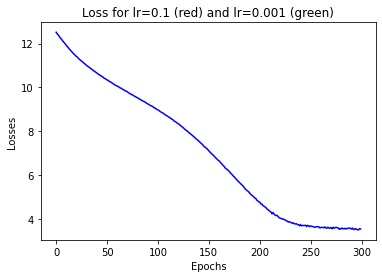

In [52]:
plt.plot(range(epochs),losses3,'b')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss for lr=0.1 (red) and lr=0.001 (green)')
plt.show()


#### 9. Running on test data

In [53]:
with torch.no_grad():
    y_preds=model.forward(X_test_cat,X_test_cont)

In [54]:
loss_test=criterion(y_preds, label_test)
loss_test**0.5

tensor(3.5872)

#### 10. Analysing the error spread

In [55]:
error=(y_preds-label_test).numpy()

                  0
count  96000.000000
mean      -0.174317
std        3.582977
min      -51.335407
25%       -1.369182
50%        0.111890
75%        1.467132
max       63.726105
Mean of error is  -0.1743
Std dev of error is   3.5830
Range of error is 115.0615
Max of error is  63.7261 at sample 48310
Max of error is -51.3354 at sample 47838


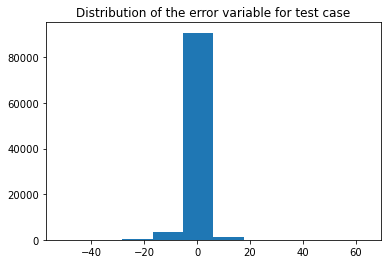

In [56]:
print(pd.DataFrame(error).describe())
print('Mean of error is {:8.4f}'.format(error.mean() ))
print('Std dev of error is {:8.4f}'.format(error.std()))
print('Range of error is {:8.4f}'.format(error.max()-error.min()))
print('Max of error is {:8.4f} at sample {}'.format(error.max(), (error.argmax())))
print('Max of error is {:8.4f} at sample {}'.format(error.min(), (error.argmin())))
plt.hist(error)
plt.title('Distribution of the error variable for test case')
plt.show()

In [57]:
one_std_dev_p=error.mean()+error.std()
one_std_dev_n=error.mean()-error.std()
ranges=((error<=one_std_dev_p) & (error>=one_std_dev_n)).sum()

In [58]:
print('% of error within one standard deviation on either side is: {:8.3f}%'.format(ranges/len(error)*100))

% of error within one standard deviation on either side is:   86.910%


#### 11. Saving the model

In [60]:
if len(losses3)==epochs:
    torch.save(model.state_dict(),'uber_model_weights.pt')
    torch.save(model,'uber_model.pkl')
else:
    print("You haven't trained this model! Only trained models should be saved!")

#### 12. Create program to directly run data transformation and through model

<b> Refer Solution Part 2.ipynb </b>